# Using MNB and Embeddings  to Predict Comment Classification

Author: Sarah Lowing

Submitted on: 10/26/2023


Like this project? Contact me on [LinkedIn](www.linkedin.com/in/sarah-lowing-330714242)


## Overview and Understanding


For this capstone project we'll be working on identifying online harassment using NLP.  Why focus on harassment?  Well, for starters, it's a problem that affects a quarter of the population in the U.S.  Additionally, according to a [2021 Pew research poll]( (https://www.pewresearch.org/internet/2021/01/13/the-state-of-online-harassment/)), 79% of respondants "say social media companies are doing an only fair or poor job at addressing online harassment or bullying on their platforms."  

"Fully 33% of women under 35 say they have been sexually harassed online", For those who identify as LBGTQA, "51% have been targeted for more severe forms of online abuse."

"Among adults who have been harassed online, roughly half of women (47%) say they think they have encountered harassment online because of their gender, whereas 18% of men who have been harassed online say the same. Similarly, about half or more Black (54%) or Hispanic online harassment targets (47%) say they were harassed due to their race or ethnicity, compared with 17% of White targets." [Plos](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0221152)


Use of social media trancends mere entertainment, and often social media sites function as conduits of information and public sentiment.  Fully 60% of the worlds adult population uses social media, and 60 percent of those use social media as their only news sorce.  As such, there can be catastophic consequence when toxic speech is amplified on those platforms.  Monitoring hate speech, and the toxic impact it can have on the fragile fabric of our social contracts is a vital and neccessary checkpoint in our information age.  But with the vast amount of usage and information it would be impossible for human monitors to catch every instance of toxic speech.

Our client, a small social media site that specializes in neighborhood forums is looking to combat an uptick in trolling on their site.  Our goal is to construct a virtual moderator, or vMOD, a NLP model that is capable of accurately predicting if a comment is harassment or not.  We have a two-fold additional benefit of both reducing the impact of toxic commentary on human moderators, who often suffer from an increased emotional toll of manually reviewing toxic material.  Mechanizing this task to such a degree that those workers could serve instead to review a small number user requests to remove flags would greatly reduce the psychological impact of language designed to inflame and marginalize.  And secondly, from a fiscal perspective, we could minimize the number of employees needed as moderators.

# Data Understanding


Our data comes from a Kaggle competetion, [Identifying Toxic Comments: Jigsaw Toxic Comment Classification Challange](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data),  a dataset comprising of 159571 data points (or comments) from Wikipedia and six target variables, toxic, severe_toxic, obscene, threat, insult, and identity_hate.  The compition was originally hosted by ConversationAI, a research arm of Alphabet.  Because the file is too large to upload to Git, I downloaded the 3 files to my cloud drive (this may take a couple of minutes depending on your download speed).  I then accessed these using OS commands to find  the directory and access said files.

  *Please see markdown below for specific directions on locating and accessing data in collab.*


Per [A Literature Survey on Algorithms for Multi-label
Learning](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.364.5612&rep=rep1&type=pdf) "in multi-label classification, predictions for an instance is a set of labels and, therefore, the prediction
can be fully correct, partially correct (with different levels of correctness) or fully incorrect. None of
these existing evaluation metrics capture such notion in their original form. This makes evaluation
of a multi-label classifier more challenging than evaluation of a single label classifier."

With this in mind we start with with all six targets present, and then try using a binary encoded version of our model for performance comparisons.


## Import Data
In this section we'll take a preliminary look at our data to get a feel for what we're working with. Let's begin with our import statements and then by taking a look at the contents of our train data directory.

In [1]:
import re, os, csv
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from google.colab import drive


import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D, SpatialDropout1D, BatchNormalization
from keras.preprocessing import sequence
from keras.metrics import Precision, Recall, F1Score



import shutil
from gensim.models import Word2Vec

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as Pipe



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
 # Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [2]:
# Set path to data.  Hint- right click on the file you want to copy file path!
drive_path = '/content/drive/MyDrive/Colab_Notebooks/jigsaw-toxic-comment-classification-challenge.zip'

In [3]:
# Navigate to file
!cp '{drive_path}' .

In [ ]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'jigsaw-toxic-comment-classification-challenge.zip', 'sample_data']


In [4]:
# Unzip zip file
!unzip '/content/jigsaw-toxic-comment-classification-challenge.zip'

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [5]:
# import csv data as pd df
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
test_labels= pd.read_csv('test_labels.csv.zip')


## Inspect Data

In [ ]:
train.shape

(159571, 8)

In [ ]:
print("Number of Train NaN:", train['comment_text'].isnull().sum())
print("Number of Test NaN:", test['comment_text'].isnull().sum())
print("Number of Label NaN:", test_labels.isnull().sum())


Number of Train NaN: 0
Number of Test NaN: 0
Number of Label NaN: id               0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
# Find comment lengths
comment_lengths = [len(comment.split()) for comment in train["comment_text"]]


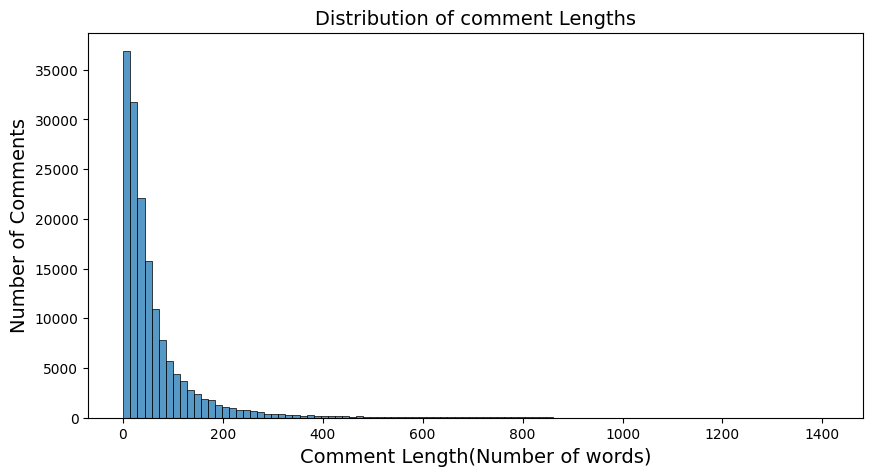

In [ ]:
# Plot comment lengths
plt.figure(figsize=(10,5))
sns.histplot(comment_lengths, bins=100);
plt.xlabel("Comment Length(Number of words)", fontsize=14);
plt.ylabel("Number of Comments", fontsize=14);
plt.title("Distribution of comment Lengths", fontsize=14);

In [ ]:
# Find lengths of longest, shortest, and average comments
len = train.comment_text.len()
print("Shortest comment:", len.min(), "words")
print("Longest comment:", len.max(), "words")
print("Average comment:", len.mean().round(0), "words")




Shortest comment: 6 words
Longest comment: 5000 words
Average comment: 394.0 words


## Non Toxic Word Visualizations
 Below, we'll create visualizations of some of these words from our nontoxic corpus.

In [ ]:
# Impost statements
import wordcloud
from wordcloud import WordCloud


In [6]:
# Function to clean corpus- we'll use this later as well

Stopwords = set(stopwords.words('english')) - {'not', 'no' }
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text) # remove all non words
    text = re.sub('\s+', ' ', text) #remove whitespace
    text = re.sub(r"https?://\S+|www\.\S+", "", text) # remove websites
    text = re.sub(r'[^\x00-\x7f]',r'', text) # remove non ACSII char
    text = re.sub(r"\n", "", text) # remove newline
    text = text.strip(' ')
    text = ' '.join(word for word in text.split() if word not in Stopwords) # delete stopwords from text


    return text

In [ ]:
# Fiter for clean speech only
clean_comments = train['comment_text'].loc[train['comment_text'] !=1].values

In [ ]:
# Use function to clean texts
clean_comments=  [clean_text(com) for com in clean_comments]


In [ ]:
# Dictionary of all words from train corpus with their counts (BoW)
words_counts = {}
for comments in clean_comments:
    for word in comments.split():
        if word not in words_counts:
            words_counts[word] = 1
        words_counts[word] += 1

size = 10000
w_sorted = sorted(words_counts, key=words_counts.get, reverse=True)[:size]
w_index = {key: rank for rank, key in enumerate(w_sorted, 0)}
i_to_w = {index:word for word, index in w_index.items()}
words = i_to_w.keys()



In [ ]:
# 10 least used words
w_sorted[-10:]

['references?',
 'Fine',
 'industry,',
 'drinks',
 'simultaneously',
 'prompt',
 'structures',
 'Jerry',
 'evaluate',
 'unethical']

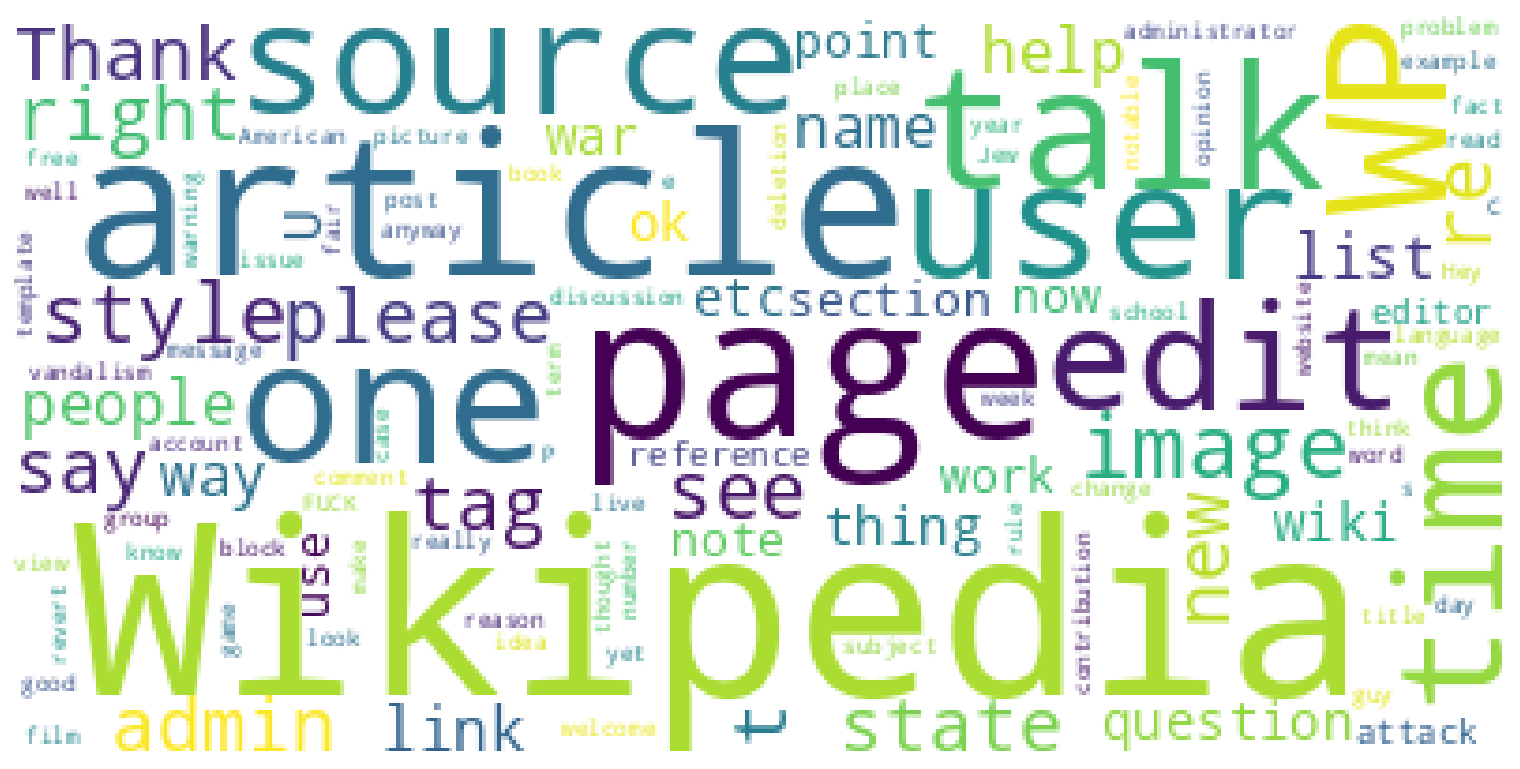

In [ ]:
# Word cloud using BoW non-toxic speech
word_cloud = WordCloud(
                       width = 200, height=175,
                       background_color='white',
                       min_font_size=7).generate(" ".join(w_sorted))

plt.figure(figsize = (15, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Examine Toxic Values
Let's take a closer look at the distribution of our toxic comments per category.  We'll skip creating a visualization for our toxic vocab, because we're pretty confident that's unneccessarily offensive- we have a good idea of what constitutes toxic speech.

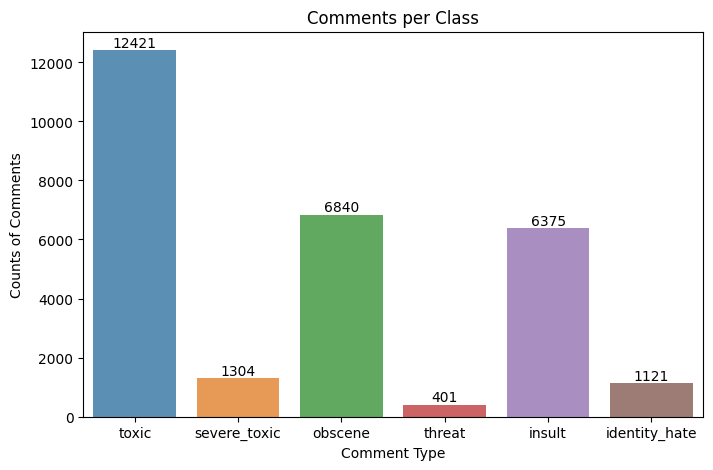

In [ ]:
cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

val_counts = y_train[cols].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x= val_counts.index, y= val_counts.values, alpha=0.8)

plt.title("Comments per Class")
plt.xlabel("Comment Type")
plt.ylabel("Counts of Comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")


plt.show()

In [ ]:
# Find total number of toxic comments in train
x=train.iloc[:,2:].sum()
print("Total number of toxic comments:", x.sum())


Total number of toxic comments: 35098


### Class Imbalance
We can see there is a clear class imbalance in our data-only 35,098 comments are considered toxic, out of our dataset of 159,571; far more records have no toxic languge than do.  We'll need to take this into account when building our model.


## Train, Test, Val Split

In order to ensure our data has no leakage, we'll perform an intitial train test split before cleaning our corpus

In [7]:
# Train dataframes
Xtrain = train['comment_text']
ytrain = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


In [8]:
#Train test split
X_train_1, X_test, y_train_1, y_test = train_test_split(Xtrain, ytrain,
                                                    test_size=0.15, random_state=42)


In [9]:
 # Val split *Validation data abels for the test data could not be used per Kaggle "value of -1 indicates it was not used for scoring; (Note: file added after competition close!)"
 X_train, X_val, y_train, y_val= train_test_split(X_train_1, y_train_1,
                                                    test_size=0.05, random_state=42)

In [ ]:
# Examine train test val
print("Train Comments:", X_train.head(2))
print("--------------------------------")

print("Test Comments:", X_test.head(2))
print("--------------------------------")

print("Val Comments:", X_val.head(2))
print("--------------------------------")

print("Train Target Variables:", y_train.head(2))
print("--------------------------------")

print("Test Target Variables:", y_test.head(2))
print("--------------------------------")

print("Val Target Variables:", y_val.head(2))
print("--------------------------------")


Train Comments: 159023    service award\nhello. i noticed you list yours...
76867     "\nwelcome!hello and welcome to wikipedia. tha...
Name: comment_text, dtype: object
--------------------------------
Test Comments: 119105    geez, are you forgetful!  we've already discus...
131631    carioca rfa \n\nthanks for your support on my ...
Name: comment_text, dtype: object
--------------------------------
Val Comments: 7608     "\n ok, i understand. -) i've been a racist fo...
20119    again again again \n\nthis is not going to sto...
Name: comment_text, dtype: object
--------------------------------
Train Target Variables:         toxic  severe_toxic  obscene  threat  insult  identity_hate
159023      0             0        0       0       0              0
76867       0             0        0       0       0              0
--------------------------------
Test Target Variables:         toxic  severe_toxic  obscene  threat  insult  identity_hate
119105      0             0        0       0

# Data Preprocessing

We'll untertake our next step, tokenizing our corpus, or splitting each comment into a series of words.  We'll have to make some decisions now about whether we remove stop words, what kinds of regex expressions we should use to clean the comments, if we should stem, lemmatize, or leave our text data as is before we come to our next step, vectorization.

Because our dataset is quite large, we'll begin by removing stop words- large datasets become highly dimensionsal after they've been vectorized, and to minimize processing times we'll need to reduce the amount of tokens we pass in to our vector.  Removing stop words- the most common words in english that have little value in this use case, will help us do so.  However, we'll keep the word "not" in our corpus, as it's use to negate bad sentiment seems highly relevant to determining the toxicity of a comment.

We'll also use regex expressions to clean up our comments by removing blanskspaces, web adresses, new line notation, non-words, and non ascii words.

We'll hold off on stemming or lemmatizing for now.  If our results from our initial models are unsatisfactory, we'll circle back to stemming our tokens.


### Clean Corpus

In [ ]:
X_train = X_train.map(lambda com : clean_text(com))
X_test = X_test.map(lambda com : clean_text(com))
X_val = X_val.map(lambda com : clean_text(com))



In [ ]:
# Check lengths of comments
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    128853.000000
mean         37.138491
std          57.355683
min           1.000000
25%           9.000000
50%          20.000000
75%          41.000000
max        1250.000000
Name: comment_text, dtype: float64

We're checking the length of our comments to see what the average input length is- if we utilize more advanced modelling techniques each comment will need to be the same length, and so it will be important to discern what a good middle ground for shortening or padding our sequences will be.  In this case, our comments average about 37 words after cleaning.  With a STD of 57, and a max count of 1250, we'd do well to err on the larger size.

## Multinomial Naive Bayes
For our first model we'll build a pipeline that uses MultinomialNB:

"... NB models generally
outperform the sophisticated, structure-sensitive
models explored in recent work..."
[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)



### Vectorization
In order to model and make predictions with our data we'll need to tranform our word tokens into vectors, or an array of numbers.

Vectorization allows our model to:
* Find word predictions
* Find word similarities
* Represent words in a lower-dimensional space
* Allow words with similar meanings to have a similar representation
* Approximate meaning

The most straightforward vectorizer in sklearn.feature_extraction.text is the CountVectorizer, which will simply count the number of each word type in each document.  We'll also use TF-IDF: Term Frequency–Inverse Document Frequency- a a numerical statistic that’s intended to reflect how important a word is to a document.  This is a slightly more sophisticated version of bag of words.

We'll use a pipeline to send both the CountVectorizer and TfidfTransformer vectors through a Multinomial Naive Bayes classifier, wrapping that in a MultiOutputClassifier to account for our 6 target variables.



Build pipeline

In [ ]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultiOutputClassifier(MultinomialNB()))
               ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print("----------------------------------------------------")
print("Test Classification Report", classification_report(y_test, y_pred,target_names=y_test.columns))



accuracy 0.9015290775401069
               precision    recall  f1-score   support

        toxic       0.99      0.18      0.30      2260
 severe_toxic       0.00      0.00      0.00       225
      obscene       0.99      0.11      0.20      1279
       threat       0.00      0.00      0.00        53
       insult       0.98      0.05      0.10      1192
identity_hate       0.00      0.00      0.00       227

    micro avg       0.99      0.12      0.21      5236
    macro avg       0.49      0.06      0.10      5236
 weighted avg       0.89      0.12      0.20      5236
  samples avg       0.02      0.01      0.01      5236



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision measures the accuracy of positive predictions, and can be used to minimize  false positives. It quantifies the number of positive class predictions that actually belong to the positive class. We had a very small percentage of false positives, only 1%.


Recall measures the completeness of positive predictions, and can be used to minimize  false positives. It quantifies the number of positive class predictions made out of all positive examples in the dataset.  The recall of our model was very poor, only 12%  of our total positives were captured.

F1 scores are the harmonic mean of precision and recall, and often is more accurate than looking solely at precision or recall.  From our F1 scores of 30%, we can see that we're doing a poor job using a multioutput model.  Let's see if switching it to a binary output helps to improve our ability to identify toxic speech.


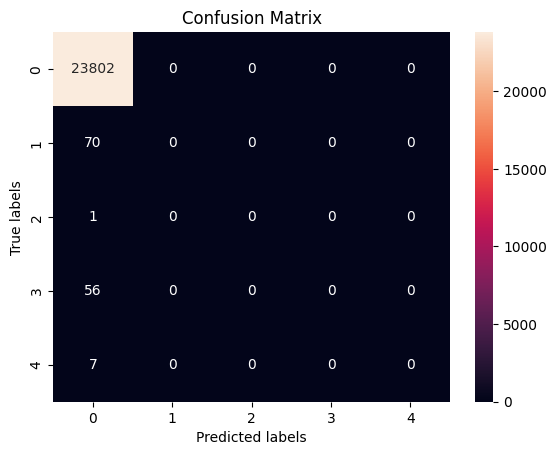

In [ ]:
lables = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_pred = np.argmax(nb.predict(X_test), axis=1)
thresh = 0.5
y_pred = (y_pred > thresh)

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, label=lables);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');



We can see that our classifier was unable to identify any toxic speech, instead labelling all speech as non-toxic.  This is likely due to our class imbalance.  In order to address that, we'll binarize our data (toxic speech is, after all, toxic speech regardless of it's form), in order to oversample our minority class.



## Binary target
We'll use exactly the same preprocessing BUT add resampling using RandomOverSampler to account for our class imbalance, AND reshape our data to binary below.

In [10]:
# Binarize target variables by converting all 6 types of toxic speech to 1 if cols= 'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'

cols=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
train['Toxic']=train[cols].max(axis=1).apply(lambda x: 1 if x ==1 else 0)

In [ ]:
# Check encoding
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


Text(0, 0.5, 'Counts of Comments')

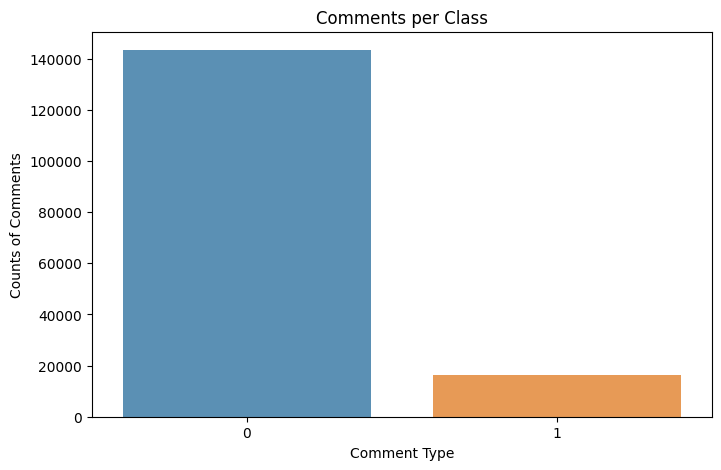

In [ ]:
# Examine class imbalance
enc_train= train[['Toxic', 'comment_text']]

val_counts = enc_train['Toxic'].value_counts()

plt.figure(figsize=(8,5))
ax = sns.barplot(x= val_counts.index, y= val_counts.values, alpha=0.8)

plt.title("Comments per Class")
plt.xlabel("Comment Type")
plt.ylabel("Counts of Comments")

In [11]:
# Train test dataframes
train_bi = train['comment_text']
ytrain_bi = train['Toxic']


In [ ]:
#Train test split
X_train_1, X_test_bi, y_train_1, y_test_bi = train_test_split(train_bi, ytrain_bi,
                                                    test_size=0.15, random_state=42)


In [ ]:
 # Val split *Validation data abels for the test data could not be used per Kaggle "value of -1 indicates it was not used for scoring; (Note: file added after competition close!)"
X_train_bi, X_val_bi, y_train_bi, y_val_bi= train_test_split(X_train_1, y_train_1,
                                                    test_size=0.05, random_state=42)

In [ ]:
#Clean text
X_train_bi = X_train_bi.map(lambda com : clean_text(com))
X_test_bi = X_test_bi.map(lambda com : clean_text(com))
X_val_bi = X_val_bi.map(lambda com : clean_text(com))

In [ ]:
#pipeline to vectorize, oversample, build and score model
nb2 = Pipe([('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('sampler', RandomOverSampler()),
            ('clf', MultinomialNB()),
])
nb2.fit(X_train_bi, y_train_bi)

y_pred_bi = nb2.predict(X_test_bi)

print('accuracy %s' % accuracy_score(y_pred_bi, y_test_bi))
print(classification_report(y_test_bi, y_pred_bi))

accuracy 0.8978108288770054
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     21542
           1       0.49      0.87      0.63      2394

    accuracy                           0.90     23936
   macro avg       0.74      0.89      0.79     23936
weighted avg       0.94      0.90      0.91     23936



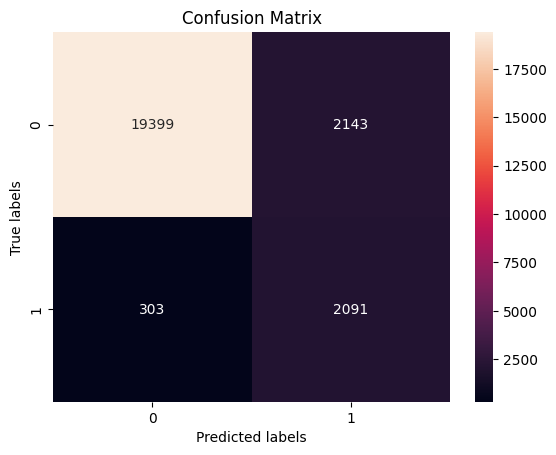

In [ ]:
# plot confusion matrix
ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_test_bi), y_pred_bi)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

This model does a much better job of identifying toxic speech, and it does minimize the number of normal comments being classified as toxic.  However it is deeply worrisome that over 1/2 of our toxic comments are being labled non-toxic.

Let's see if using a neural network with embeddings can improve our ability to detect toxic speech.

#  Model Using Embeddings
An embedding is a mapping of a discrete — categorical — variable to a vector of continuous numbers. In the context of neural networks, embeddings are low-dimensional, learned continuous vector representations of discrete variables. Neural network embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space, meaning "the semantic relationships between words are reflected in the distance and direction of the vectors."  [Word embeddings for sentiment analysis](https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e).  Special thanks to
Bert Carremans, the author of that article, from which much of the following code is adapted.

Neural network embeddings have 3 primary purposes:

1.  Finding nearest neighbors in the embedding space. These can be used to make recommendations based on user interests or cluster categories.
2.  As input to a machine learning model for a supervised task.
3.  For visualization of concepts and relations between categories.

This makes modelling using embeddings the perfect choice for this task- we're looking to find the relationship between certain tokens and classification of speech as toxic. In particular, were looking to capture semantic relationships between words. Words with similar meanings tend to have similar vector representations, allowing it to understand word context and similarity.  We'll see if this applies to our test data in this application.

We'll use a vocab size of 500



In [12]:
# Import statements
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from gensim.models import KeyedVectors
from tensorflow.keras.callbacks import EarlyStopping



In [25]:
# set important variables
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [26]:
train_e = train['comment_text']
ytrain_e = train['Toxic']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(train_e, ytrain_e, test_size=0.2)



In [28]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [29]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

183314

In [30]:
# Tokenize and pad train set
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [31]:
# Tokenize and pad test set
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [32]:
# examine shape
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (127656, 500)
Shape of testing tensor:  (31915, 500)


### Model Architecture
Below we'll build a relatively simple neural network with embeddings.  We'll employ the following layers:


* __Embedding:__ An embedding layer is a hidden layer in a neural network. It maps input information from a high-dimensional to a lower-dimensional space. This allows the network to learn more about the relationship between inputs and to process the data more efficiently.

* __GlobalAveragePooling1D:__ returns a fixed-length output, allows model to handle input of variable length.

* __Dense:__ a Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer. It's the most basic layer in neural networks.  Adding dense layers can empower networks ability to classify features better, but for this starter neural network we'll just use 1

* __Dropout:__ a regularization approach that prevents overfitting by dropping nodes, thereby ensuring that no units are codependent with one another.

* __Denese:__ our last dense layer with sigmoid function for binary encoded target

In [33]:
# Define parameters
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [40]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [42]:
# compile model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['acc', f1_m,precision_m, recall_m])

In [43]:
# fit model
num_epochs = 6
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/6
3990/3990 - 12s - loss: 0.1829 - acc: 0.9355 - f1_m: 0.5087 - precision_m: 0.6989 - recall_m: 0.4372 - val_loss: 0.1889 - val_acc: 0.9338 - val_f1_m: 0.4753 - val_precision_m: 0.6935 - val_recall_m: 0.3922 - 12s/epoch - 3ms/step
Epoch 2/6
3990/3990 - 11s - loss: 0.1814 - acc: 0.9362 - f1_m: 0.5105 - precision_m: 0.6966 - recall_m: 0.4398 - val_loss: 0.1978 - val_acc: 0.9302 - val_f1_m: 0.5611 - val_precision_m: 0.6532 - val_recall_m: 0.5454 - 11s/epoch - 3ms/step
Epoch 3/6
3990/3990 - 12s - loss: 0.1803 - acc: 0.9363 - f1_m: 0.5125 - precision_m: 0.7027 - recall_m: 0.4416 - val_loss: 0.1828 - val_acc: 0.9353 - val_f1_m: 0.5107 - val_precision_m: 0.7131 - val_recall_m: 0.4339 - 12s/epoch - 3ms/step
Epoch 4/6
3990/3990 - 12s - loss: 0.1790 - acc: 0.9367 - f1_m: 0.5178 - precision_m: 0.7136 - recall_m: 0.4416 - val_loss: 0.1847 - val_acc: 0.9351 - val_f1_m: 0.5417 - val_precision_m: 0.7036 - val_recall_m: 0.4825 - 12s/epoch - 3ms/step
Epoch 5/6
3990/3990 - 12s - loss: 0.1783 - a

In [46]:
# evaluate the model
'''
These are global metrics, but Keras works in batches.
We'll see only the scores for the last batch run.
As a result, it might be more misleading than helpful,
but we'll examine them in conjunction with our confusion matrix.
'''
loss, accuracy, f1_score, precision, recall = model.evaluate(testing_padded, y_test, verbose=0)

In [48]:
print("Accuracy", accuracy )
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy 0.9354222416877747
F1 Score: 0.5049117207527161
Precision: 0.7118903398513794
Recall: 0.4254811406135559


998/998 [==============================] - 1s 1ms/step


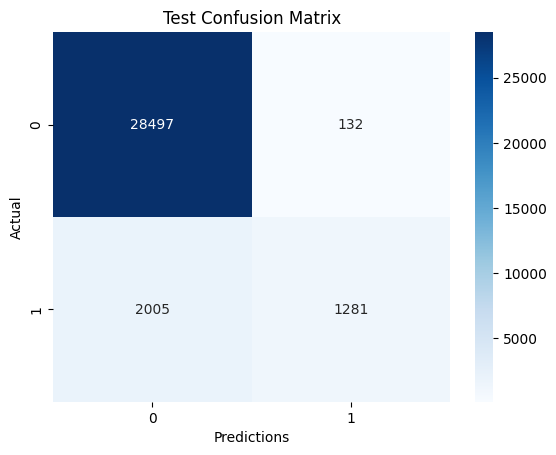

In [ ]:
# plot test confusion matrix
y_hat_test = model.predict(testing_padded)
thresh = 0.5
y_pred = (y_hat_test > thresh).astype(int)
y_true = y_test.astype(int)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

## Conclusions

As we can see, our model has vastly improved it's ability to find toxic speech.  Although use of word embeddings has exacerbated our false negatives (the number of normal comments labelled toxic), we did see a significant reduction in the number of false positives (non toxic comments percieved as toxic).  However, the a significant increase in the number of false negatievs remains problematic.  Our model must be able to do everything- we want to ensure that we are catching as many toxic comments as possible, as well as not mislabling nontoxic comments, which would be problematic for users.  

We can begin to use our embedded  neural network  for our vMod, as a way to reduce workload on comment screeners.  We had the lowest incidences of false positives with that model- it was fairly successfull at identifying toxic speech, missing only 132 instances in our test set.




## Next Steps

It's highly likely that the difficulty we're experiencing in differentiating toxic from non-toxic speech could be overcome with some small changes.  Note that our model drastically improved it's ability to predict toxic speech with embeddings- a hint that in order to improve our recall and accuracy we could coontinue to experiment with tuning our parameters- even something as simple as shifting our vocab up to 5000. Our first steps should be to experiment further with this model.

Additionally, we'd begun work on a BERT model, (Bidirectional Encoder Representations from Transformers), a cutting edge pretrained black box NLP model developed by Google.  BERT models use embeddings (vectors representing tokens(words)), encoders (tranformers that manipulate embeddings), and un-embedding.  BERT learns latent representations of words and sentences in context through a masking and replacement.  With a 30,000 word vocabulary, it has the strongest starting place for classification tasks of the available technologies.  Our second step will be to complete this model, and compare it's precision (the measure of false negatives).  

